<a href="https://colab.research.google.com/github/lucianosilva-github/paradigmas/blob/main/PARADIGMAS%20-%20AULA%2009%20-%20REVISAO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**LINGUAGENS E PARADIGMAS - AULA 09 - REVISÃO**

**Prof. Luciano Silva**

**OBJETIVOS DA AULA:**

*   Revisar os conceitos e implementações para a Prova Intermediária (PI)

In [1]:
!pip install rply

Considere parte da linguagem Pascal mostrada abaixo:


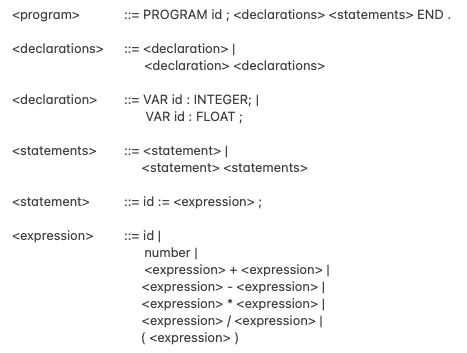

Nesta versão do Pascal vamos considerar as seguintes restrições:

*   palavras reservadas (PROGRAM, END, VAR, INTEGER e FLOAT) devem ser sempre escritas em maiúsculas
*   INTEGER operado com INTEGER sempre gera um INTEGER
*   INTEGER operado com FLOAT sempre gera um resultado FLOAT
*.  FLOAT operado com FLOAT sempre gera um resultado FLOAT
*.  Uma expressão INTEGER pode ser atribuída a um id declarado como INTEGER ou FLOAT. Porém, uma expressão FLOAT só pode ser atribuída a um id declarado como FLOAT.



**QUESTÃO 1.** Escreva um exemplo de programa Pascal que seja aceito por esta gramática. Este programa deverá ser usado nos testes subsequentes.

In [ ]:
PROGRAM exemplo;

VAR x:INTEGER;
VAR y:FLOAT;
VAR z:FLOAT;

x:=3;
y:=4.5;
z:=x+y;

END .

**QUESTÃO 2.**Implemente um analisador léxico para esta gramática:





In [2]:
from rply import LexerGenerator

lg = LexerGenerator()

lg.add('NUMBER', r'\d+(\.\d+)?')
lg.add('PLUS', r'\+')
lg.add('MINUS', r'-')
lg.add('MUL', r'\*')
lg.add('DIV', r'/')
lg.add('OPEN_PARENS', r'\(')
lg.add('CLOSE_PARENS', r'\)')

lg.add('INTEGER', r'INTEGER')
lg.add('FLOAT', r'FLOAT')
lg.add('PROGRAM', r'PROGRAM')
lg.add('VAR', r'VAR')
lg.add('END', r'END')
lg.add('POINT', r'\.')
lg.add('ID', r'[a-zA-z][a-zA-z0-9]*')
lg.add('EQUALS', r':=')
lg.add('SEP', r':')
lg.add('SEMICOL', r';')

lg.ignore('\s+')

lexer = lg.build()

**QUESTÃO 3.**Implemente classes para representar as árvores sintáticas geradas por esta gramática e que sejam capazes de receber visitors.

In [3]:
#ÁRVORE SINTÁTICA PREPARADA PARA RECEBER VISITORS

from rply.token import BaseBox

class Program(BaseBox):
    def __init__(self, id, decls,stmts):
        self.id = id
        self.decls = decls
        self.stmts = stmts

    def accept(self, visitor):
        visitor.visit_program(self)

class Declarations(BaseBox):
    def __init__(self, decl,decls):
        self.decl = decl
        self.decls = decls

    def accept(self, visitor):
        visitor.visit_declarations(self)

class Declaration(BaseBox):
    def __init__(self, id,tp):
        self.id = id
        self.tp = tp


    def accept(self, visitor):
        visitor.visit_declaration(self)

class Statements(BaseBox):
    def __init__(self, stmt,stmts):
        self.stmt = stmt
        self.stmts = stmts

    def accept(self, visitor):
        visitor.visit_statements(self)

class Statement(BaseBox):
    def __init__(self, id,expr):
        self.id = id
        self.expr = expr

    def accept(self, visitor):
        visitor.visit_statement(self)

class Expr(BaseBox):
    def accept(self, visitor):
        method_name = 'visit_{}'.format(self.__class__.__name__.lower())
        visit = getattr(visitor, method_name)
        visit(self)

class Id(Expr):
    def __init__(self, value):
        self.value = value

class Number(Expr):
    def __init__(self, value):
        self.value = value


class BinaryOp(Expr):
    def __init__(self, left, right):
        self.left = left
        self.right = right

class Add(BinaryOp):
  pass


class Sub(BinaryOp):
  pass


class Mul(BinaryOp):
  pass


class Div(BinaryOp):
  pass


**QUESTÃO 4.**Implemente um analisador sintático para esta gramnática.

In [6]:
#ANALISADOR SINTÁTICO

from rply import ParserGenerator

pg = ParserGenerator(
    # A list of all token names, accepted by the lexer.
    ['NUMBER', 'OPEN_PARENS', 'CLOSE_PARENS',
     'PLUS', 'MINUS', 'MUL', 'DIV', 'INTEGER', 'FLOAT', 'ID','SEMICOL',
     'EQUALS','PROGRAM', 'VAR','END','SEP','POINT'
    ],
    # A list of precedence rules with ascending precedence, to
    # disambiguate ambiguous production rules.
    precedence=[
        ('left', ['PLUS', 'MINUS']),
        ('left', ['MUL', 'DIV'])
    ]
)

@pg.production('program : PROGRAM ID SEMICOL declarations statements END POINT')
def prog(p):
    return Program(p[1].getstr(),p[3],p[4])

@pg.production('declarations : declaration')
def vardecls(p):
    return Declarations(p[0],None)

@pg.production('declarations : declaration declarations')
def vardecls(p):
    return Declarations(p[0],p[1])

@pg.production('declaration : VAR ID SEP INTEGER SEMICOL')
def vardecl_integer(p):
    return Declaration(p[1].getstr(), "integer")

@pg.production('declaration : VAR ID SEP FLOAT SEMICOL')
def vardecl_float(p):
    return Declaration(p[1].getstr(), "float")


@pg.production('statements : statement')
def statements_statement(p):
    return Statements(p[0],None)

@pg.production('statements : statement statements')
def statement_statements(p):
    return Statements(p[0],p[1])

@pg.production('statement : ID EQUALS expression SEMICOL')
def statements_statement(p):
    return Statement(p[0].getstr(),p[2])


@pg.production('expression : ID')
def expression_id(p):
    return Id(p[0].getstr())

@pg.production('expression : NUMBER')
def expression_number(p):
    if "." in p[0].getstr():
      return Number(float(p[0].getstr()))
    return Number(int(p[0].getstr()))

@pg.production('expression : OPEN_PARENS expression CLOSE_PARENS')
def expression_parens(p):
    return p[1]

@pg.production('expression : expression PLUS expression')
@pg.production('expression : expression MINUS expression')
@pg.production('expression : expression MUL expression')
@pg.production('expression : expression DIV expression')
def expression_binop(p):
    left = p[0]
    right = p[2]
    if p[1].gettokentype() == 'PLUS':
        return Add(left, right)
    elif p[1].gettokentype() == 'MINUS':
        return Sub(left, right)
    elif p[1].gettokentype() == 'MUL':
        return Mul(left, right)
    elif p[1].gettokentype() == 'DIV':
        return Div(left, right)
    else:
        raise AssertionError('Oops, this should not be possible!')

parser = pg.build()

In [9]:
t=lexer.lex('PROGRAM exemplo;VAR x:INTEGER;VAR y:FLOAT;VAR z:FLOAT;x:=3;y:=4.5;z:=x+y;END .')
print(list(t))

[Token('PROGRAM', 'PROGRAM'), Token('ID', 'exemplo'), Token('SEMICOL', ';'), Token('VAR', 'VAR'), Token('ID', 'x'), Token('SEP', ':'), Token('INTEGER', 'INTEGER'), Token('SEMICOL', ';'), Token('VAR', 'VAR'), Token('ID', 'y'), Token('SEP', ':'), Token('FLOAT', 'FLOAT'), Token('SEMICOL', ';'), Token('VAR', 'VAR'), Token('ID', 'z'), Token('SEP', ':'), Token('FLOAT', 'FLOAT'), Token('SEMICOL', ';'), Token('ID', 'x'), Token('EQUALS', ':='), Token('NUMBER', '3'), Token('SEMICOL', ';'), Token('ID', 'y'), Token('EQUALS', ':='), Token('NUMBER', '4.5'), Token('SEMICOL', ';'), Token('ID', 'z'), Token('EQUALS', ':='), Token('ID', 'x'), Token('PLUS', '+'), Token('ID', 'y'), Token('SEMICOL', ';'), Token('END', 'END'), Token('POINT', '.')]


In [7]:
arvore=parser.parse(lexer.lex('PROGRAM exemplo;VAR x:INTEGER;VAR y:FLOAT;VAR z:FLOAT;x:=3;y:=4.5;z:=x+y;END .'))

**QUESTÃO 5.**Implemente um visitor para montagem da tabela de símbolos.

In [11]:
ST={}

class Visitor(object):
  pass

class SymbolTable(Visitor):
    def visit_program(self, prog):
        prog.decls.accept(self)

    def visit_declarations(self, d):
        d.decl.accept(self)
        if d.decls!=None:
          d.decls.accept(self)

    def visit_declaration(self, d):
        ST[d.id]=d.tp



In [14]:
arvore=parser.parse(lexer.lex('PROGRAM exemplo;VAR x:INTEGER;VAR y:FLOAT;VAR z:FLOAT;x:=3;y:=4.5;z:=x+y;END .'))
arvore.accept(SymbolTable())
print(ST)

{'x': 'integer', 'y': 'float', 'z': 'float'}


In [ ]:
r

**QUESTÃO 6.**Implemente um visitor para decoração da árvore sintática.

In [16]:
# VISITOR - DECORATOR

class Decorator(Visitor):

    def visit_program(self, i):
        i.stmts.accept(self)

    def visit_statements(self, d):
        d.stmt.accept(self)
        if d.stmts!=None:
          d.stmts.accept(self)

    def visit_statement(self, i):
        if i.id in ST:
          i.decor_type=ST[i.id]
        else:
          raise AssertionError('id not declared')
        i.expr.accept(self)



    def visit_id(self, i):
        if i.value in ST:
          i.decor_type=ST[i.value]
        else:
          raise AssertionError('id not declared')


    def visit_number(self, i):
        if "." in str(i.value):
          i.decor_type="float"
        else:
          i.decor_type="int"


    def visit_add(self, a):
        a.left.accept(self)
        a.right.accept(self)
        if a.left.decor_type=="float" or a.right.decor_type=="float":
          a.decor_type="float"
        else:
          a.decor_type="int"


    def visit_sub(self, a):
        a.left.accept(self)
        a.right.accept(self)
        if a.left.decor_type=="float" or a.right.decor_type=="float":
          a.decor_type="float"
        else:
          a.decor_type="int"

    def visit_mul(self, a):
        a.left.accept(self)
        a.right.accept(self)
        if a.left.decor_type=="float" or a.right.decor_type=="float":
          a.decor_type="float"
        else:
          a.decor_type="int"

    def visit_div(self, a):
        a.left.accept(self)
        a.right.accept(self)
        if a.left.decor_type=="float" or a.right.decor_type=="float":
          a.decor_type="float"
        else:
          a.decor_type="int"


In [17]:
arvore=parser.parse(lexer.lex('PROGRAM exemplo;VAR x:INTEGER;VAR y:FLOAT;VAR z:FLOAT;x:=3;y:=4.5;z:=x+y;END .'))
arvore.accept(SymbolTable())
arvore.accept(Decorator())

**QUESTÃO 7.**Implemente um visitor para verificação de tipos.

In [ ]:
# VISITOR - TYPE VERIFIER

class TypeVerifier(Visitor):

    def visit_prog(self, i):
        i.stmts.accept(self)

    def visit_statements(self, d):
        d.stmt.accept(self)
        if d.stmts!=None:
          d.stmts.accept(self)

    def visit_statement(self, d):
        d.atrib.accept(self)

    def visit_atrib(self, i):
        if i.decor_type!=i.expr.decor_type:
          raise AssertionError('type error')


**QUESTÃO 8.**Implemente um visitor para geração de código intermediário.



In [ ]:
class IntermediateCode(Visitor):


  def __init__(self):
    self.ic=[] #lista com código intermediário

  def visit_prog(self, i):
        i.stmts.accept(self)

  def visit_statements(self, d):
        d.stmt.accept(self)
        if d.stmts!=None:
          d.stmts.accept(self)

  def visit_statement(self, d):
        d.atrib.accept(self)

  def visit_atrib(self, i):
    i.expr.accept(self)
    self.ic.append("sto 0 "+i.id)


  def visit_id(self, i):
    self.ic.append("lod 0 "+i.value)


  def visit_number(self, i):
    self.ic.append("lit 0 "+str(i.value))


  def visit_add(self, a):
    a.left.accept(self)
    a.right.accept(self)
    self.ic.append("opr 0 2")


  def visit_sub(self, a):
    a.left.accept(self)
    a.right.accept(self)
    self.ic.append("opr 0 3")

  def visit_mul(self, a):
    a.left.accept(self)
    a.right.accept(self)
    self.ic.append("opr 0 4")

  def visit_div(self, a):
    a.left.accept(self)
    a.right.accept(self)
    self.ic.append("opr 0 5")

**QUESTÃO 9.**Teste a sua implementação com o programa que vc escreveu na questão 1.

In [ ]:
arvore=parser.parse(lexer.lex('AQUI VAI O SEU PROGRAMA NUMA ÚNICA LINHA'))
arvore.accept(SymbolTable())
arvore.accept(Decorator())
arvore.accept(TypeVerifier())
icvisitor=IntermediateCode()
arvore.accept(icvisitor)
ic=icvisitor.ic   #código intermediário gerado
print(ic)

['lit 0 2', 'lod 0 x', 'opr 0 4', 'lit 0 60', 'lod 0 y', 'opr 0 5', 'opr 0 3', 'sto 0 z']
